In [25]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='pyfolio')
warnings.filterwarnings('ignore', category=UserWarning, module='zipline')

selected_portfolio_weights = pd.read_csv("selected_portfolio_weights.csv")
print(selected_portfolio_weights)

   Ticker        24
0    AAPL  0.006377
1    ABBV  0.078065
2     AMD  0.001279
3    AVGO  0.001064
4    BIDU  0.073690
5     CME  0.013281
6    COST  0.008289
7    EQIX  0.011696
8     FXE  0.001579
9     FXY  0.200750
10    GLD  0.000301
11   GOOG  0.001811
12     HD  0.013374
13   INTC  0.020884
14     KO  0.004776
15   META  0.000302
16   MSFT  0.000875
17   NVDA  0.000218
18    PEP  0.003477
19    PFF  0.186570
20     PG  0.007265
21   SCHD  0.000678
22    TLT  0.000736
23    TSM  0.004133
24    VEA  0.002377
25    VNQ  0.181245
26    VWO  0.001396
27    VYM  0.000456
28    WMT  0.000017
29    XOM  0.173039


In [26]:
# ============================================================================
# ZIPLINE BACKTEST WITH FEES AND TRANSACTION COSTS
# ============================================================================

from zipline.api import (
    order_target_percent,
    order,
    record,
    symbol,
    set_commission,
    set_slippage,
    schedule_function,
    date_rules,
    time_rules
)
from zipline.finance import commission, slippage
from zipline import run_algorithm
import pandas as pd
import numpy as np
import pyfolio as pf
import matplotlib.pyplot as plt

In [27]:
# ============================================================================
# STEP 1: CREATE CUSTOM BUNDLE FOR YOUR ASSETS
# ============================================================================

from zipline.data.bundles import register
import yfinance as yf

# Your asset universe (excluding SPY which is benchmark)
bundle_tickers = list(selected_portfolio_weights["Ticker"]) + [
    'SPY', 'QQQ'  # Include SPY & QQQ for benchmark
]

def term_project_bundle(environ,
                        asset_db_writer,
                        minute_bar_writer,
                        daily_bar_writer,
                        adjustment_writer,
                        calendar,
                        start_session,
                        end_session,
                        cache,
                        show_progress,
                        output_dir):
    """
    Custom bundle for term project assets with 25 years of data.
    """
    print(f"Ingesting {len(bundle_tickers)} tickers from {start_session} to {end_session}...")
    
    # Download data from Yahoo Finance
    data = yf.download(
        bundle_tickers,
        start=start_session,
        end=end_session + pd.Timedelta(days=1),
        auto_adjust=False,
        group_by='ticker',
        progress=show_progress
    )
    
    metadata = []
    daily_bar_data = {}
    
    for ticker in bundle_tickers:
        try:
            if len(bundle_tickers) == 1:
                df = data.copy()
            else:
                df = data[ticker].copy()
            
            # Rename columns for Zipline
            df = df.rename(columns={
                'Open': 'open',
                'High': 'high',
                'Low': 'low',
                'Close': 'close',
                'Volume': 'volume',
            })
            
            # Use adjusted close
            if 'Adj Close' in df.columns:
                df['close'] = df['Adj Close']
            
            df = df[['open', 'high', 'low', 'close', 'volume']].dropna()
            
            if df.empty:
                print(f"  ⚠ Skipping {ticker}: no data")
                continue
            
            # Metadata
            metadata.append({
                'symbol': ticker,
                'asset_name': ticker,
                'start_date': df.index[0].to_pydatetime(),
                'end_date': df.index[-1].to_pydatetime(),
                'first_traded': df.index[0].to_pydatetime(),
                'auto_close_date': (df.index[-1] + pd.Timedelta(days=1)).to_pydatetime(),
                'exchange': 'NYSE',
            })
            
            daily_bar_data[ticker] = df
            print(f"  ✓ {ticker}: {len(df)} bars")
            
        except Exception as e:
            print(f"  ✗ {ticker}: {e}")
    
    # Write metadata
    metadata_df = pd.DataFrame(metadata)
    asset_db_writer.write(equities=metadata_df)
    
    # Get symbol to SID mapping
    symbol_to_sid = {row['symbol']: idx for idx, row in metadata_df.iterrows()}
    
    # Write daily bars
    daily_bar_data_with_sids = [
        (symbol_to_sid[symbol], df)
        for symbol, df in daily_bar_data.items()
    ]
    daily_bar_writer.write(daily_bar_data_with_sids, show_progress=show_progress)
    
    # Write empty adjustments
    adjustment_writer.write()
    
    print(f"\n✓ Bundle complete: {len(metadata)} assets")

# Register bundle
register(
    'term-project-bundle',
    term_project_bundle,
    calendar_name='NYSE',
)

print("✓ Bundle 'term-project-bundle' registered")



✓ Bundle 'term-project-bundle' registered


C:\Users\Sujala\AppData\Local\Temp\tmp42ak9vac\ipykernel_8752\55548248.py:105: UserWarning: Overwriting bundle with name 'term-project-bundle'
  register(


In [28]:
# ============================================================================
# STEP 2: INGEST THE BUNDLE
# ============================================================================

from zipline.data.bundles import ingest

print("\nIngesting bundle data...")
try:
    ingest('term-project-bundle', show_progress=True)
    print("✓ Bundle ingestion completed")
except Exception as e:
    print(f"✗ Ingestion error: {e}")



Ingesting bundle data...
Ingesting 32 tickers from 1990-01-02 00:00:00 to 2026-11-13 00:00:00...


[*********************100%***********************]  32 of 32 completed
c:\AJ_MSDS\.venv\Lib\site-packages\zipline\assets\asset_writer.py:321: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mappings.groupby(["symbol", "country_code"], group_keys=False).apply(


  ✓ AAPL: 9036 bars
  ✓ ABBV: 3239 bars
  ✓ AMD: 9036 bars
  ✓ AVGO: 4096 bars
  ✓ BIDU: 5103 bars
  ✓ CME: 5773 bars
  ✓ COST: 9036 bars
  ✓ EQIX: 6354 bars
  ✓ FXE: 5014 bars
  ✓ FXY: 4721 bars
  ✓ GLD: 5282 bars
  ✓ GOOG: 5346 bars
  ✓ HD: 9036 bars
  ✓ INTC: 9036 bars
  ✓ KO: 9036 bars
  ✓ META: 3394 bars
  ✓ MSFT: 9036 bars
  ✓ NVDA: 6747 bars
  ✓ PEP: 9036 bars
  ✓ PFF: 4689 bars
  ✓ PG: 9036 bars
  ✓ SCHD: 3539 bars
  ✓ TLT: 5864 bars
  ✓ TSM: 7070 bars
  ✓ VEA: 4608 bars
  ✓ VNQ: 5318 bars
  ✓ VWO: 5206 bars
  ✓ VYM: 4779 bars
  ✓ WMT: 9036 bars
  ✓ XOM: 9036 bars
  ✓ SPY: 8257 bars
  ✓ QQQ: 6715 bars
Merging daily equity files:

✓ Bundle complete: 32 assets
✓ Bundle ingestion completed



LOADING AND PLOTTING SPY DATA FROM BUNDLE
Loading SPY data from 1999-11-15 to 2024-11-15...
✓ Loaded 6292 trading days
  Date range: 1999-11-15 to 2024-11-15
  Price range: $50.09 to $591.57

SPY PERFORMANCE METRICS (Last 25 Years)
Initial Price (Nov 1999):     $88.28
Final Price (Nov 2024):       $578.71
Total Return:                 555.51%
Annualized Return:            9.87%
Annualized Volatility:        19.39%
Sharpe Ratio:                 0.4856
Maximum Drawdown:             -55.19%
$100,000 Initial Investment:  $655,506.60


C:\Users\Sujala\AppData\Local\Temp\tmp42ak9vac\ipykernel_8752\1726203488.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


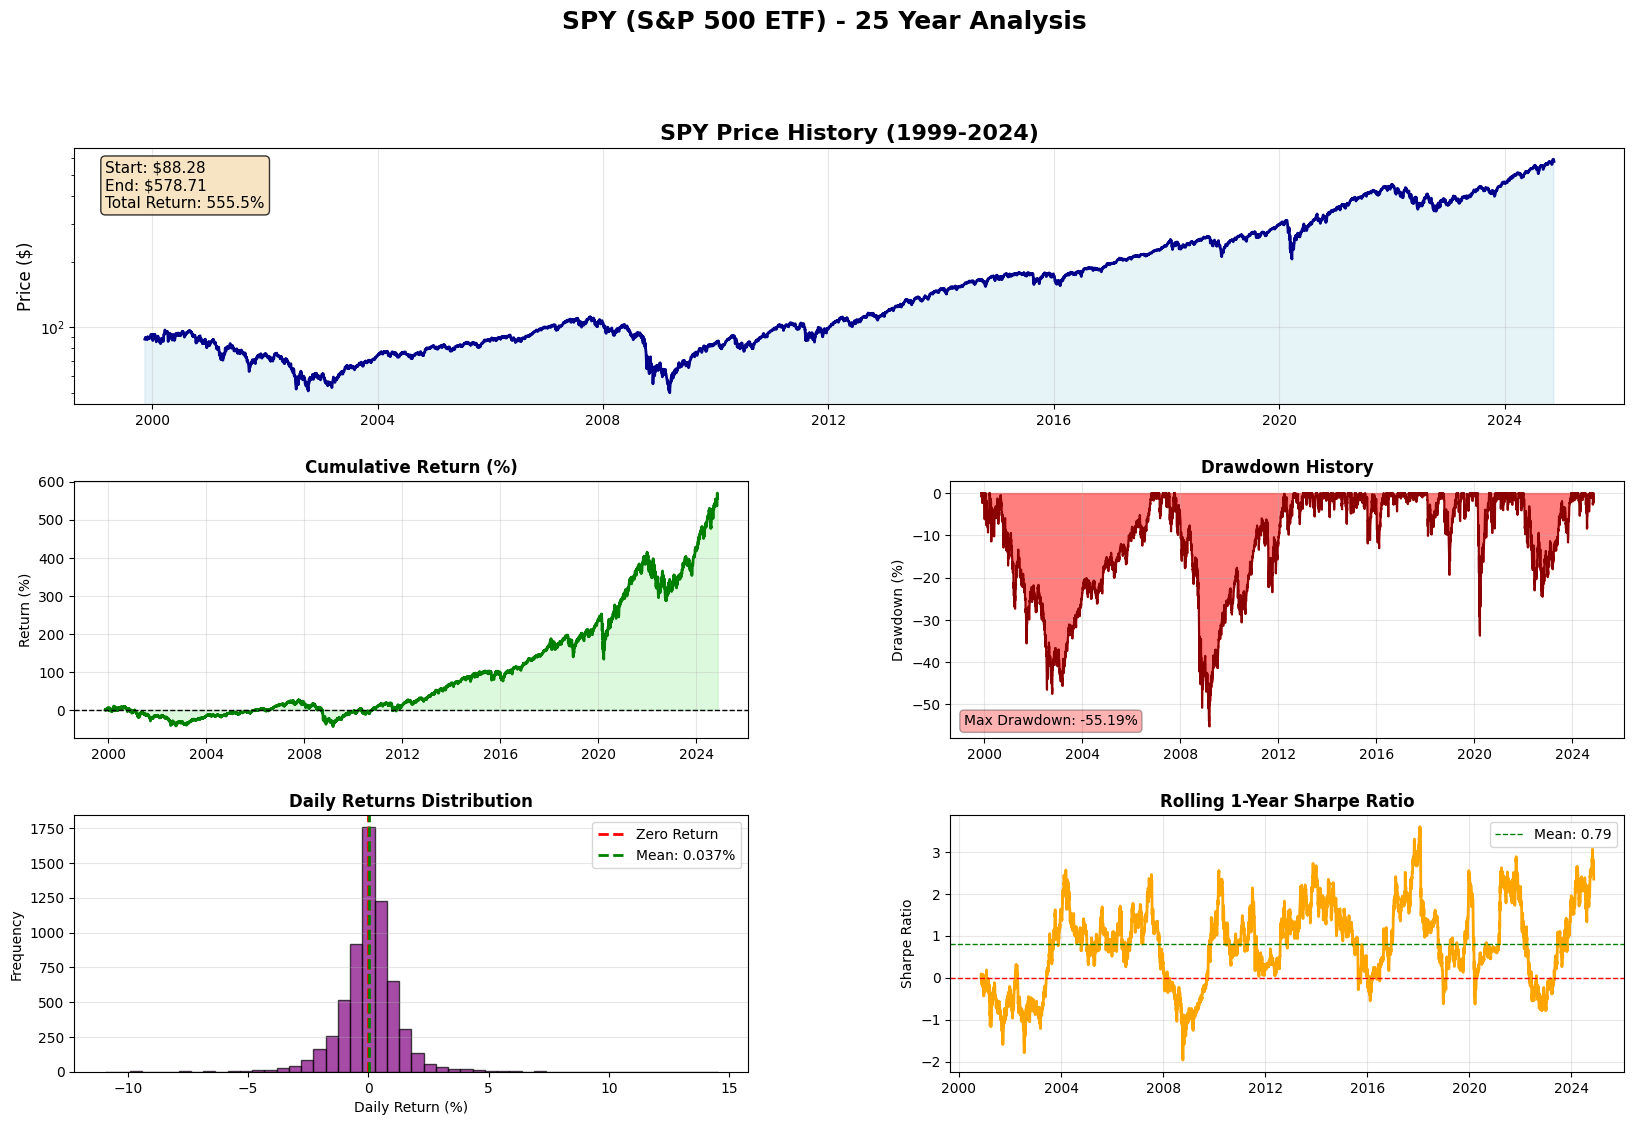


YEARLY RETURNS


,Year,Return (%)
0,1999,5.11
1,2000,-9.74
2,2001,-11.76
3,2002,-21.58
4,2003,28.18
5,2004,10.70
6,2005,4.83
7,2006,15.85
8,2007,5.15
9,2008,-36.79



Positive Years: 20 out of 26 (76.9%)
Best Year: 32.31% (2013)
Worst Year: -36.79% (2008)

✓ SPY analysis complete!


In [29]:
# ============================================================================
# PLOT SPY FOR LAST 25 YEARS FROM BUNDLE
# ============================================================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\n" + "="*80)
print("LOADING AND PLOTTING SPY DATA FROM BUNDLE")
print("="*80)

try:
    from zipline.data.data_portal import DataPortal
    from zipline.data import bundles
    import exchange_calendars as xcals
    
    # Load the bundle
    bundle_data = bundles.load('term-project-bundle')
    
    # FIX: Use the SAME trading calendar from the bundle
    trading_calendar = bundle_data.equity_daily_bar_reader.trading_calendar
    
    # Date range (last 25 years)
    end_date = pd.Timestamp('2024-11-15')
    start_date = end_date - pd.DateOffset(years=25)
    
    print(f"Loading SPY data from {start_date.date()} to {end_date.date()}...")
    
    # Create data portal - using bundle's calendar
    data_portal = DataPortal(
        bundle_data.asset_finder,
        trading_calendar=trading_calendar,
        first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
        equity_daily_reader=bundle_data.equity_daily_bar_reader,
    )
    
    # Get SPY asset
    spy_asset = bundle_data.asset_finder.lookup_symbol('SPY', as_of_date=None)
    
    # Get trading days
    trading_days = trading_calendar.sessions_in_range(start_date, end_date)
    
    # Load SPY OHLCV data
    spy_data_list = []
    for day in trading_days:
        try:
            open_price = data_portal.get_spot_value(spy_asset, 'open', day, 'daily')
            high_price = data_portal.get_spot_value(spy_asset, 'high', day, 'daily')
            low_price = data_portal.get_spot_value(spy_asset, 'low', day, 'daily')
            close_price = data_portal.get_spot_value(spy_asset, 'close', day, 'daily')
            volume = data_portal.get_spot_value(spy_asset, 'volume', day, 'daily')
            
            spy_data_list.append({
                'date': day,
                'Open': open_price,
                'High': high_price,
                'Low': low_price,
                'Close': close_price,
                'Volume': volume
            })
        except:
            pass
    
    # Create DataFrame
    spy_df = pd.DataFrame(spy_data_list)
    spy_df.set_index('date', inplace=True)
    spy_df.index = spy_df.index.tz_localize(None)
    
    print(f"✓ Loaded {len(spy_df)} trading days")
    print(f"  Date range: {spy_df.index[0].date()} to {spy_df.index[-1].date()}")
    print(f"  Price range: ${spy_df['Close'].min():.2f} to ${spy_df['Close'].max():.2f}")
    
    # Calculate returns and statistics
    initial_price = spy_df['Close'].iloc[0]
    final_price = spy_df['Close'].iloc[-1]
    total_return = (final_price / initial_price - 1) * 100
    
    daily_returns = spy_df['Close'].pct_change().dropna()
    ann_return = ((1 + daily_returns.mean()) ** 252 - 1) * 100
    ann_vol = daily_returns.std() * np.sqrt(252) * 100
    sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    
    # Calculate drawdown
    cumulative_max = spy_df['Close'].cummax()
    drawdown = (spy_df['Close'] - cumulative_max) / cumulative_max * 100
    max_drawdown = drawdown.min()
    
    print(f"\n{'='*80}")
    print("SPY PERFORMANCE METRICS (Last 25 Years)")
    print(f"{'='*80}")
    print(f"Initial Price (Nov 1999):     ${initial_price:.2f}")
    print(f"Final Price (Nov 2024):       ${final_price:.2f}")
    print(f"Total Return:                 {total_return:.2f}%")
    print(f"Annualized Return:            {ann_return:.2f}%")
    print(f"Annualized Volatility:        {ann_vol:.2f}%")
    print(f"Sharpe Ratio:                 {sharpe:.4f}")
    print(f"Maximum Drawdown:             {max_drawdown:.2f}%")
    print(f"$100,000 Initial Investment:  ${100000 * (final_price/initial_price):,.2f}")
    
    # ========================================================================
    # COMPREHENSIVE PLOTTING
    # ========================================================================
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Price Chart (Log Scale)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(spy_df.index, spy_df['Close'], linewidth=2, color='darkblue')
    ax1.fill_between(spy_df.index, spy_df['Close'], alpha=0.3, color='lightblue')
    ax1.set_title('SPY Price History (1999-2024)', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.text(0.02, 0.95, f'Start: ${initial_price:.2f}\nEnd: ${final_price:.2f}\nTotal Return: {total_return:.1f}%', 
             transform=ax1.transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Plot 2: Cumulative Return (%)
    ax2 = fig.add_subplot(gs[1, 0])
    cumulative_return = (spy_df['Close'] / initial_price - 1) * 100
    ax2.plot(cumulative_return.index, cumulative_return, linewidth=2, color='green')
    ax2.fill_between(cumulative_return.index, 0, cumulative_return, alpha=0.3, color='lightgreen')
    ax2.set_title('Cumulative Return (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Return (%)', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    
    # Plot 3: Drawdown Chart
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.fill_between(drawdown.index, 0, drawdown, alpha=0.5, color='red')
    ax3.plot(drawdown.index, drawdown, linewidth=1.5, color='darkred')
    ax3.set_title('Drawdown History', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Drawdown (%)', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.text(0.02, 0.05, f'Max Drawdown: {max_drawdown:.2f}%', 
             transform=ax3.transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
    
    # Plot 4: Daily Returns Distribution
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.hist(daily_returns * 100, bins=50, alpha=0.7, color='purple', edgecolor='black')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Return')
    ax4.axvline(daily_returns.mean() * 100, color='green', linestyle='--', 
                linewidth=2, label=f'Mean: {daily_returns.mean()*100:.3f}%')
    ax4.set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Daily Return (%)', fontsize=10)
    ax4.set_ylabel('Frequency', fontsize=10)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Plot 5: Rolling 1-Year Sharpe Ratio
    ax5 = fig.add_subplot(gs[2, 1])
    rolling_sharpe = (daily_returns.rolling(252).mean() / 
                      daily_returns.rolling(252).std()) * np.sqrt(252)
    ax5.plot(rolling_sharpe.index, rolling_sharpe, linewidth=2, color='orange')
    ax5.axhline(0, color='red', linestyle='--', linewidth=1)
    ax5.axhline(rolling_sharpe.mean(), color='green', linestyle='--', linewidth=1,
                label=f'Mean: {rolling_sharpe.mean():.2f}')
    ax5.set_title('Rolling 1-Year Sharpe Ratio', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Sharpe Ratio', fontsize=10)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    plt.suptitle('SPY (S&P 500 ETF) - 25 Year Analysis', 
                 fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # YEARLY BREAKDOWN
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("YEARLY RETURNS")
    print(f"{'='*80}")
    
    yearly_returns = daily_returns.resample('YE').apply(lambda x: (1 + x).prod() - 1) * 100
    
    yearly_df = pd.DataFrame({
        'Year': yearly_returns.index.year,
        'Return (%)': yearly_returns.values
    })
    
    display(yearly_df.round(2))
    
    positive_years = (yearly_returns > 0).sum()
    print(f"\nPositive Years: {positive_years} out of {len(yearly_returns)} ({positive_years/len(yearly_returns)*100:.1f}%)")
    print(f"Best Year: {yearly_returns.max():.2f}% ({yearly_returns.idxmax().year})")
    print(f"Worst Year: {yearly_returns.min():.2f}% ({yearly_returns.idxmin().year})")
    
    print("\n✓ SPY analysis complete!")

except Exception as e:
    print(f"✗ Error: {e}")
    import traceback
    traceback.print_exc()

In [37]:
# ============================================================================
# STEP 3: DEFINE STRATEGY WITH FEES (FIXED)
# ============================================================================

def initialize(context):
    """
    Initialize strategy with NSGA-II optimized weights and fee structure.
    """
    # FIX: Read weights properly from CSV
    weights_df = selected_portfolio_weights.copy()
    
    # The CSV has columns: 'Ticker' and a numeric column (likely '24')
    # Rename columns properly
    if len(weights_df.columns) == 2:
        weights_df.columns = ['Ticker', 'Weight']
    elif 'Weight' not in weights_df.columns:
        # Find the numeric column
        numeric_cols = weights_df.select_dtypes(include=['float64', 'int64']).columns
        if len(numeric_cols) > 0:
            weights_df = weights_df.rename(columns={numeric_cols[0]: 'Weight'})
    
    # Normalize weights to sum to 1
    total_weight = weights_df['Weight'].sum()
    weights_df['Weight'] = weights_df['Weight'] / total_weight
    
    print(f"\nPortfolio Weights (normalized):")
    print(weights_df.to_string(index=False))
    print(f"\nTotal weight: {weights_df['Weight'].sum():.6f}")
    
    # Create universe mapping ticker to Zipline symbol objects
    context.universe = {}
    context.target_weights = {}
    
    for _, row in weights_df.iterrows():
        ticker = row['Ticker']
        weight = row['Weight']
        
        try:
            context.universe[ticker] = symbol(ticker)
            context.target_weights[ticker] = weight
        except Exception as e:
            print(f"⚠️  Could not load {ticker}: {e}")
    
    print(f"\n✓ Initialized with {len(context.universe)} assets")
    
    # ========================================================================
    # SET BENCHMARK TO SPY (CRITICAL FIX)
    # ========================================================================
    from zipline.api import set_benchmark
    context.spy = symbol('SPY')
    set_benchmark(context.spy)
    
    # ========================================================================
    # FEE STRUCTURE
    # ========================================================================
    
    # Transaction costs: 10 bps per trade (0.001 = 0.1%)
    set_commission(commission.PerDollar(cost=0.001))
    
    # Slippage: volume-based model
    set_slippage(slippage.VolumeShareSlippage(
        volume_limit=0.025,  # Don't trade more than 2.5% of daily volume
        price_impact=0.1     # Price impact coefficient
    ))
    
    # Management fee tracking (1% annual = 0.01/252 daily)
    context.management_fee_annual = 0.01
    context.management_fee_daily = context.management_fee_annual / 252
    
    context.quarterly_dividend_rate = 0.01  # 1% quarterly dividend
    context.last_quarter = None  # Track quarter changes

    # Performance fee tracking (20% on excess returns above SPY)
    context.performance_fee_rate = 0.20
    context.hwm = None  # High-water mark for performance fee
    context.last_year = None  # Track year changes
    
    # ========================================================================
    # SCHEDULING
    # ========================================================================
    
    # Monthly rebalancing (matches your tactical strategy)
    schedule_function(
        rebalance_portfolio,
        date_rules.month_start(),
        time_rules.market_open()
    )
    
    # Daily management fee deduction
    schedule_function(
        deduct_management_fee,
        date_rules.every_day(),
        time_rules.market_close()
    )
    
    # Check for quarter-end and year-end every day
    schedule_function(
        check_quarter_and_year_end,
        date_rules.every_day(),
        time_rules.market_close()
    )

def rebalance_portfolio(context, data):
    """
    Rebalance to target weights from NSGA-II.
    Transaction costs automatically applied by Zipline.
    """
    for ticker, asset in context.universe.items():
        if data.can_trade(asset):
            target_weight = context.target_weights.get(ticker, 0)
            order_target_percent(asset, target_weight)
    
    # Record portfolio metrics
    record(
        portfolio_value=context.portfolio.portfolio_value,
        leverage=context.account.leverage,
    )

def deduct_management_fee(context, data):
    """
    Deduct daily management fee (0.01/252 per day).
    """
    fee_amount = context.portfolio.portfolio_value * context.management_fee_daily
    
    # Simulate fee by reducing cash (in reality this is tracked separately)
    # Note: Zipline doesn't allow direct cash modification, so we track it
    record(mgmt_fee_paid=fee_amount)

def check_quarter_and_year_end(context, data):
    """
    Check if quarter or year has changed and charge fees accordingly.
    """
    current_date = data.current_dt
    current_quarter = (current_date.month - 1) // 3 + 1
    current_year = current_date.year
    
    # Initialize on first run
    if context.last_quarter is None:
        context.last_quarter = current_quarter
        context.last_year = current_year
        record(quarterly_dividend_paid=0, perf_fee_paid=0)
        return
    
    # Check for quarter change (pay dividend)
    if current_quarter != context.last_quarter:
        pay_quarterly_dividend(context, data)
        context.last_quarter = current_quarter
    else:
        record(quarterly_dividend_paid=0)
    
    # Check for year change (charge performance fee)
    if current_year > context.last_year:
        charge_performance_fee(context, data)
        context.last_year = current_year
    else:
        record(perf_fee_paid=0)

def pay_quarterly_dividend(context, data):
    """
    Pay quarterly dividend (1% per quarter) by selling proportional shares
    AND removing the cash from the portfolio.
    """
    # Calculate quarterly dividend amount (1% of portfolio value)
    quarterly_dividend_amount = context.portfolio.portfolio_value * context.quarterly_dividend_rate
    
    # Calculate total position value
    total_position_value = sum([
        context.portfolio.positions[asset].amount * data.current(asset, 'price')
        for asset in context.portfolio.positions
        if data.can_trade(asset) and context.portfolio.positions[asset].amount > 0
    ])
    
    if total_position_value > 0:
        # Calculate the reduction factor for each position
        reduction_factor = quarterly_dividend_amount / total_position_value
        
        # Sell proportional amount from each position
        for ticker, asset in context.universe.items():
            if asset in context.portfolio.positions and data.can_trade(asset):
                current_position = context.portfolio.positions[asset]
                
                if current_position.amount > 0:
                    # Calculate shares to sell (proportional to dividend)
                    shares_to_sell = current_position.amount * reduction_factor
                    
                    # Sell the shares
                    order(asset, -shares_to_sell)
    
    # ========================================================================
    # KEY FIX: Track cumulative cash that should be removed
    # ========================================================================
    
    # Initialize cumulative dividend tracking if not exists
    if not hasattr(context, 'cumulative_dividends_paid'):
        context.cumulative_dividends_paid = 0
    
    # Add to cumulative total
    context.cumulative_dividends_paid += quarterly_dividend_amount
    
    # Record both current and cumulative dividends
    record(
        quarterly_dividend_paid=quarterly_dividend_amount,
        cumulative_dividends=context.cumulative_dividends_paid
    )

def charge_performance_fee(context, data):
    """
    Charge annual performance fee on gains above high-water mark.
    Only charged on excess returns vs SPY benchmark.
    """
    current_value = context.portfolio.portfolio_value
    
    # Initialize high-water mark
    if context.hwm is None:
        context.hwm = context.portfolio.starting_cash
    
    # Get SPY performance for benchmark comparison
    # Use 252 trading days (approx 1 year)
    try:
        spy_price_history = data.history(context.spy, 'price', 252, '1d')
        
        # FIX: Use .iloc for positional indexing instead of bracket notation
        spy_annual_return = (spy_price_history.iloc[-1] / spy_price_history.iloc[0]) - 1
        
        benchmark_value = context.hwm * (1 + spy_annual_return)
        
        # Only charge fee if portfolio exceeds benchmark + HWM
        if current_value > max(benchmark_value, context.hwm):
            excess_gain = current_value - max(benchmark_value, context.hwm)
            perf_fee = excess_gain * context.performance_fee_rate
            
            context.hwm = current_value - perf_fee  # Update HWM after fee
            
            record(perf_fee_paid=perf_fee)
        else:
            record(perf_fee_paid=0)
    except:
        # Not enough history yet
        record(perf_fee_paid=0)
        
def analyze(context, perf):
    """
    Analyze results and generate performance report.
    """
    print("\n" + "="*80)
    print("ZIPLINE BACKTEST RESULTS (with fees and transaction costs)")
    print("="*80)
    
    # Calculate total fees and dividends
    total_mgmt_fees = perf['mgmt_fee_paid'].sum() if 'mgmt_fee_paid' in perf.columns else 0
    total_perf_fees = perf['perf_fee_paid'].sum() if 'perf_fee_paid' in perf.columns else 0
    total_dividends = perf['quarterly_dividend_paid'].sum() if 'quarterly_dividend_paid' in perf.columns else 0
    total_fees = total_mgmt_fees + total_perf_fees
    
    # ========================================================================
    # ADJUST FOR DIVIDENDS THAT SHOULD HAVE BEEN WITHDRAWN
    # ========================================================================
    
    # Get cumulative dividends over time
    if 'cumulative_dividends' in perf.columns:
        cumulative_dividends_series = perf['cumulative_dividends']
    else:
        cumulative_dividends_series = perf['quarterly_dividend_paid'].cumsum()
    
    # Adjusted portfolio value (removing dividends that should have left the portfolio)
    adjusted_portfolio_value = perf['portfolio_value'] - cumulative_dividends_series
    
    # Performance metrics - UNADJUSTED (as reported by Zipline)
    unadjusted_final_value = perf['portfolio_value'].iloc[-1]
    unadjusted_total_return = (unadjusted_final_value / perf['portfolio_value'].iloc[0]) - 1
    
    # Performance metrics - ADJUSTED (true investor returns after dividends withdrawn)
    adjusted_final_value = adjusted_portfolio_value.iloc[-1]
    adjusted_total_return = (adjusted_final_value / perf['portfolio_value'].iloc[0]) - 1
    
    portfolio_returns = perf['returns'].dropna()
    
    # ========================================================================
    # CALCULATE ALPHA AND BETA VS SPY
    # ========================================================================

    if 'benchmark_period_return' in perf.columns and 'algorithm_period_return' in perf.columns:
        # Get daily returns from cumulative returns properly
        # Method: Calculate returns from the cumulative return values
        
        # Portfolio cumulative returns
        portfolio_cumulative = perf['algorithm_period_return']
        
        # Benchmark cumulative returns
        benchmark_cumulative = perf['benchmark_period_return']
        
        # Convert cumulative to daily returns
        # Daily return = (1 + cumulative_today) / (1 + cumulative_yesterday) - 1
        portfolio_daily_returns = (1 + portfolio_cumulative) / (1 + portfolio_cumulative.shift(1)) - 1
        benchmark_daily_returns = (1 + benchmark_cumulative) / (1 + benchmark_cumulative.shift(1)) - 1
        
        # Remove first row (NaN) and align
        aligned_data = pd.DataFrame({
            'portfolio': portfolio_daily_returns,
            'benchmark': benchmark_daily_returns
        }).dropna()
        
        if len(aligned_data) > 252:  # Need at least 1 year of data
            # Calculate beta using covariance method
            covariance = aligned_data['portfolio'].cov(aligned_data['benchmark'])
            benchmark_variance = aligned_data['benchmark'].var()
            beta = covariance / benchmark_variance if benchmark_variance != 0 else 0
            
            # Calculate annualized returns
            portfolio_annual_return = (1 + aligned_data['portfolio'].mean()) ** 252 - 1
            benchmark_annual_return = (1 + aligned_data['benchmark'].mean()) ** 252 - 1
            risk_free_rate = 0.02  # 2% risk-free rate
            
            # Calculate alpha using CAPM: α = Rp - [Rf + β(Rm - Rf)]
            alpha = portfolio_annual_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate))
            
            # Print debug info
            print(f"\n{'='*80}")
            print("ALPHA/BETA CALCULATION DEBUG")
            print(f"{'='*80}")
            print(f"Data points used: {len(aligned_data)}")
            print(f"Portfolio mean daily return: {aligned_data['portfolio'].mean():.6f}")
            print(f"Benchmark mean daily return: {aligned_data['benchmark'].mean():.6f}")
            print(f"Portfolio annualized return: {portfolio_annual_return:.4f} ({portfolio_annual_return*100:.2f}%)")
            print(f"Benchmark annualized return: {benchmark_annual_return:.4f} ({benchmark_annual_return*100:.2f}%)")
            print(f"Covariance: {covariance:.8f}")
            print(f"Benchmark variance: {benchmark_variance:.8f}")
            print(f"Beta: {beta:.4f}")
            print(f"Alpha: {alpha:.4f} ({alpha*100:.2f}%)")
            print(f"{'='*80}")
        else:
            alpha = 0
            beta = 0
            print("\n⚠️  Not enough data to calculate alpha/beta (need 252+ days)")
    else:
        alpha = 0
        beta = 0
        print("\n⚠️  Benchmark data not available in results")    
        
    # ========================================================================
    # PRINT SUMMARY - SHOWING BOTH UNADJUSTED AND ADJUSTED
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    
    print(f"\n--- UNADJUSTED (as reported by Zipline) ---")
    print(f"Final Portfolio Value: ${unadjusted_final_value:,.2f}")
    print(f"Total Return: {unadjusted_total_return:.2%}")
    
    print(f"\n--- ADJUSTED (after dividend withdrawals) ---")
    print(f"Adjusted Final Value: ${adjusted_final_value:,.2f}")
    print(f"Adjusted Total Return: {adjusted_total_return:.2%}")
    print(f"⚠️  This represents true investor returns after ${total_dividends:,.2f} in dividends withdrawn")
    
    print(f"\n--- RISK-ADJUSTED METRICS ---")
    print(f"Alpha (vs SPY): {alpha:.4f} ({alpha*100:.2f}%)")
    print(f"Beta (vs SPY): {beta:.4f}")
    print(f"Sharpe Ratio: {(portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)):.4f}")
    
    print(f"\n--- FEES ---")
    print(f"Total Management Fees: ${total_mgmt_fees:,.2f}")
    print(f"Total Performance Fees: ${total_perf_fees:,.2f}")
    print(f"Total All Fees: ${total_fees:,.2f}")
    print(f"Fees as % of Adjusted Final Value: {(total_fees/adjusted_final_value)*100:.2f}%")
    
    print(f"\n--- DIVIDENDS ---")
    print(f"Total Dividends Paid: ${total_dividends:,.2f}")
    print(f"Dividends as % of Adjusted Final Value: {(total_dividends/adjusted_final_value)*100:.2f}%")
    
    # ========================================================================
    # PLOT RESULTS - WITH ADJUSTED VALUES
    # ========================================================================
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    
    # Portfolio value - BOTH UNADJUSTED AND ADJUSTED
    ax = axes[0, 0]
    perf['portfolio_value'].plot(ax=ax, linewidth=2, color='blue', label='Unadjusted', alpha=0.5)
    adjusted_portfolio_value.plot(ax=ax, linewidth=2.5, color='darkgreen', label='Adjusted (post-dividend)')
    ax.set_title('Portfolio Value Over Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Value ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Returns distribution
    ax = axes[0, 1]
    portfolio_returns.hist(ax=ax, bins=50, alpha=0.7, color='blue')
    ax.set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Return')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Portfolio vs Benchmark
    ax = axes[0, 2]
    if 'benchmark_period_return' in perf.columns:
        perf['algorithm_period_return'].plot(ax=ax, linewidth=2, label='Portfolio', color='blue')
        perf['benchmark_period_return'].plot(ax=ax, linewidth=2, label='SPY Benchmark', color='red', alpha=0.7)
        ax.set_title('Cumulative Returns: Portfolio vs SPY', fontsize=12, fontweight='bold')
        ax.set_ylabel('Cumulative Return')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Cumulative fees and dividends
    ax = axes[1, 0]
    if 'mgmt_fee_paid' in perf.columns and 'perf_fee_paid' in perf.columns:
        cum_mgmt = perf['mgmt_fee_paid'].cumsum()
        cum_perf = perf['perf_fee_paid'].cumsum()
        cum_div = cumulative_dividends_series
        
        cum_mgmt.plot(ax=ax, label='Management Fees', linewidth=2, color='orange')
        cum_perf.plot(ax=ax, label='Performance Fees', linewidth=2, color='red')
        cum_div.plot(ax=ax, label='Dividends Paid', linewidth=2.5, linestyle='--', color='darkgreen')
        
        ax.set_title('Cumulative Fees & Dividends', fontsize=12, fontweight='bold')
        ax.set_ylabel('Cumulative Amount ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Rolling Sharpe Ratio (252-day)
    ax = axes[1, 1]
    rolling_sharpe = (portfolio_returns.rolling(252).mean() / 
                      portfolio_returns.rolling(252).std() * np.sqrt(252))
    rolling_sharpe.plot(ax=ax, linewidth=1.5, color='purple')
    ax.set_title('Rolling Sharpe Ratio (1-Year)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Sharpe Ratio')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    
    # Drawdown - USING ADJUSTED VALUES
    # Drawdown Comparison - PORTFOLIO AND SPY
    ax = axes[1, 2]

    # Portfolio drawdown (using adjusted values)
    running_max = adjusted_portfolio_value.expanding().max()
    portfolio_drawdown = (adjusted_portfolio_value - running_max) / running_max

    # SPY drawdown (from benchmark data)
    if 'benchmark_period_return' in perf.columns:
        # Calculate SPY portfolio value from benchmark returns
        initial_value = perf['portfolio_value'].iloc[0]
        spy_cumulative = perf['benchmark_period_return']
        spy_value = initial_value * (1 + spy_cumulative)
        
        # Calculate SPY drawdown
        spy_running_max = spy_value.expanding().max()
        spy_drawdown = (spy_value - spy_running_max) / spy_running_max
        
        # Plot both drawdowns
        portfolio_drawdown.plot(ax=ax, linewidth=2, color='darkgreen', label='Portfolio', alpha=0.8)
        spy_drawdown.plot(ax=ax, linewidth=2, color='red', label='SPY', alpha=0.6, linestyle='--')
        
        # Fill areas
        ax.fill_between(portfolio_drawdown.index, portfolio_drawdown, 0, alpha=0.3, color='darkgreen')
        ax.fill_between(spy_drawdown.index, spy_drawdown, 0, alpha=0.2, color='red')
        
        # Add legend and labels
        ax.legend(loc='lower left', fontsize=10)
        ax.set_title('Drawdown Comparison: Portfolio vs SPY (Adjusted)', fontsize=12, fontweight='bold')
    else:
        # Fallback: just portfolio drawdown
        portfolio_drawdown.plot(ax=ax, linewidth=1.5, color='red', alpha=0.7)
        ax.fill_between(portfolio_drawdown.index, portfolio_drawdown, 0, alpha=0.3, color='red')
        ax.set_title('Portfolio Drawdown (Adjusted)', fontsize=12, fontweight='bold')

    ax.set_ylabel('Drawdown (%)')
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.grid(True, alpha=0.3)

    # Add max drawdown annotations
    portfolio_max_dd = portfolio_drawdown.min()
    ax.text(0.02, 0.05, f'Portfolio Max DD: {portfolio_max_dd:.2%}', 
            transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))

    if 'benchmark_period_return' in perf.columns:
        spy_max_dd = spy_drawdown.min()
        ax.text(0.02, 0.12, f'SPY Max DD: {spy_max_dd:.2%}', 
                transform=ax.transAxes, fontsize=9,
                bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # STORE ADJUSTED VALUES FOR SPY COMPARISON
    # ========================================================================
    
    # Store in context for later use
    context.adjusted_portfolio_value = adjusted_portfolio_value
    context.adjusted_final_value = adjusted_final_value
    context.total_dividends_withdrawn = total_dividends
    
    # ========================================================================
    # PYFOLIO TEARSHEET
    # ========================================================================

    print("\n" + "="*80)
    print("GENERATING PYFOLIO TEARSHEET")
    print("="*80)

    try:
        returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
        
        # FIX: Extract benchmark returns from perf dataframe instead of downloading
        if 'benchmark_period_return' in perf.columns:
            # Calculate benchmark daily returns from cumulative returns
            benchmark_cumulative = perf['benchmark_period_return']
            benchmark_returns = (1 + benchmark_cumulative) / (1 + benchmark_cumulative.shift(1)) - 1
            benchmark_returns = benchmark_returns.dropna()
            
            print(f"✓ Using SPY benchmark from backtest results")
            print(f"  Benchmark returns: {len(benchmark_returns)} days")
            
            pf.create_full_tear_sheet(
                returns,
                positions=positions,
                transactions=transactions,
                benchmark_rets=benchmark_returns,
                live_start_date='2020-02-27',
                round_trips=False  # Disable to avoid warnings
            )
        else:
            # Fallback: No benchmark comparison
            print("⚠️  Benchmark data not available, generating tearsheet without benchmark")
            pf.create_full_tear_sheet(
                returns,
                positions=positions,
                transactions=transactions,
                live_start_date='2020-02-27',
                round_trips=False
            )
            
    except Exception as e:
        print(f"⚠️  Could not generate PyFolio tearsheet: {e}")
        print("Continuing without tearsheet...")
        import traceback
        traceback.print_exc()


RUNNING ZIPLINE BACKTEST
Period: 1999-01-01 to 2025-10-31
Initial Capital: $100,000
Management Fee: 1% annual
Performance Fee: 20% on excess returns vs SPY
Transaction Costs: 10 bps per trade

Portfolio Weights (normalized):
Ticker   Weight
  AAPL 0.006377
  ABBV 0.078065
   AMD 0.001279
  AVGO 0.001064
  BIDU 0.073690
   CME 0.013281
  COST 0.008289
  EQIX 0.011696
   FXE 0.001579
   FXY 0.200750
   GLD 0.000301
  GOOG 0.001811
    HD 0.013374
  INTC 0.020884
    KO 0.004776
  META 0.000302
  MSFT 0.000875
  NVDA 0.000218
   PEP 0.003477
   PFF 0.186570
    PG 0.007265
  SCHD 0.000678
   TLT 0.000736
   TSM 0.004133
   VEA 0.002377
   VNQ 0.181245
   VWO 0.001396
   VYM 0.000456
   WMT 0.000017
   XOM 0.173039

Total weight: 1.000000

✓ Initialized with 30 assets

ZIPLINE BACKTEST RESULTS (with fees and transaction costs)

ALPHA/BETA CALCULATION DEBUG
Data points used: 6749
Portfolio mean daily return: 0.000302
Benchmark mean daily return: 0.000398
Portfolio annualized return: 0.0790

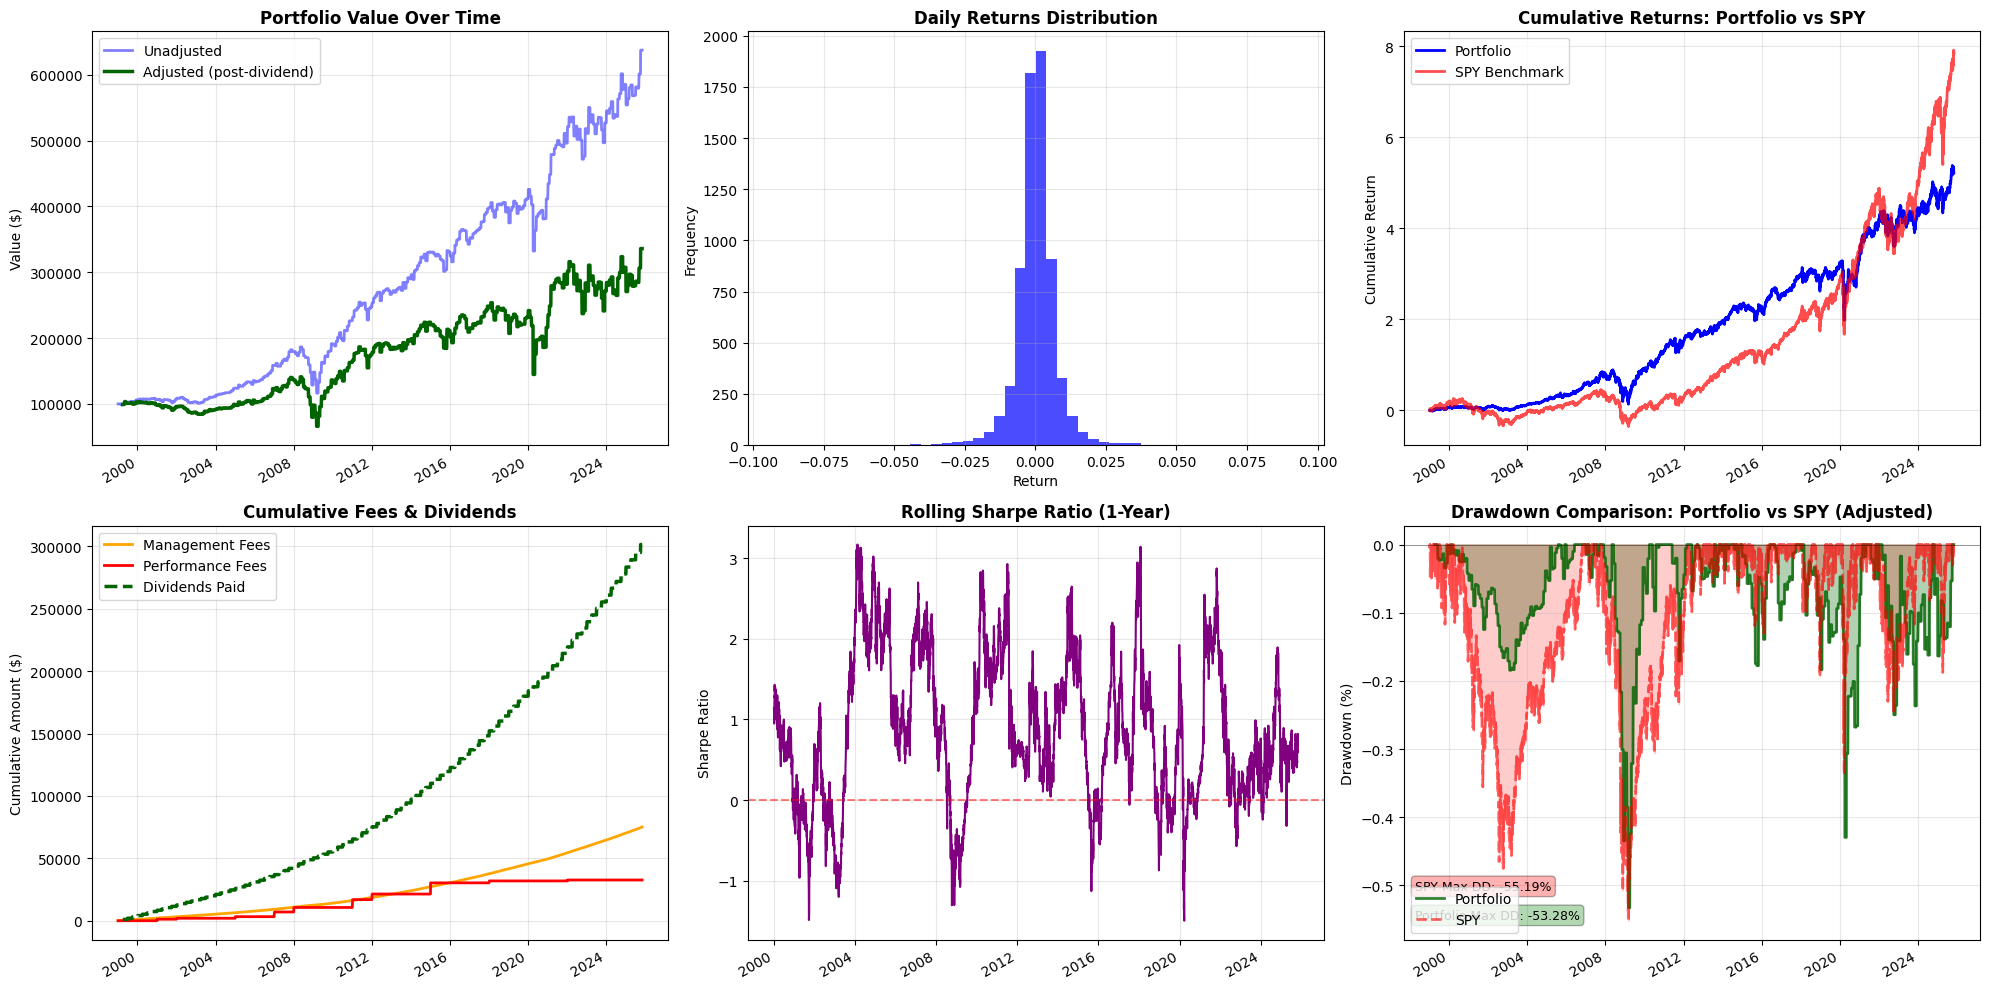


GENERATING PYFOLIO TEARSHEET
✓ Using SPY benchmark from backtest results
  Benchmark returns: 6749 days


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,39.89,2008-05-19,2009-03-06,2009-11-16,391
1,30.50,2020-02-12,2020-03-23,2020-12-15,220
2,14.61,2022-03-30,2022-10-14,2023-01-13,208
3,12.59,2018-01-26,2018-12-24,2019-04-08,312
4,12.48,2011-07-26,2011-08-08,2012-01-23,130


c:\AJ_MSDS\.venv\Lib\site-packages\pyfolio\plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Dotcom,0.01%,-0.86%,0.92%
Lehman,-0.15%,-6.08%,5.33%
9/11,0.01%,-0.98%,1.19%
US downgrade/European Debt Crisis,0.03%,-5.25%,4.50%
Fukushima,0.12%,-0.80%,0.92%
US Housing,-0.10%,-0.66%,0.62%
EZB IR Event,-0.02%,-0.83%,1.03%
Aug07,0.10%,-1.54%,2.12%
Mar08,0.16%,-1.66%,3.14%
Sept08,-0.29%,-6.08%,5.33%


Top 10 long positions of all time,max
sid,
FXY,26.42%
VNQ,23.11%
PFF,22.98%
XOM,21.22%
BIDU,10.85%
ABBV,9.41%
EQIX,4.52%
INTC,2.93%
CME,1.88%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
FXY,26.42%
VNQ,23.11%
PFF,22.98%
XOM,21.22%
BIDU,10.85%
ABBV,9.41%
EQIX,4.52%
INTC,2.93%
CME,1.88%



✓ Zipline backtest completed successfully!


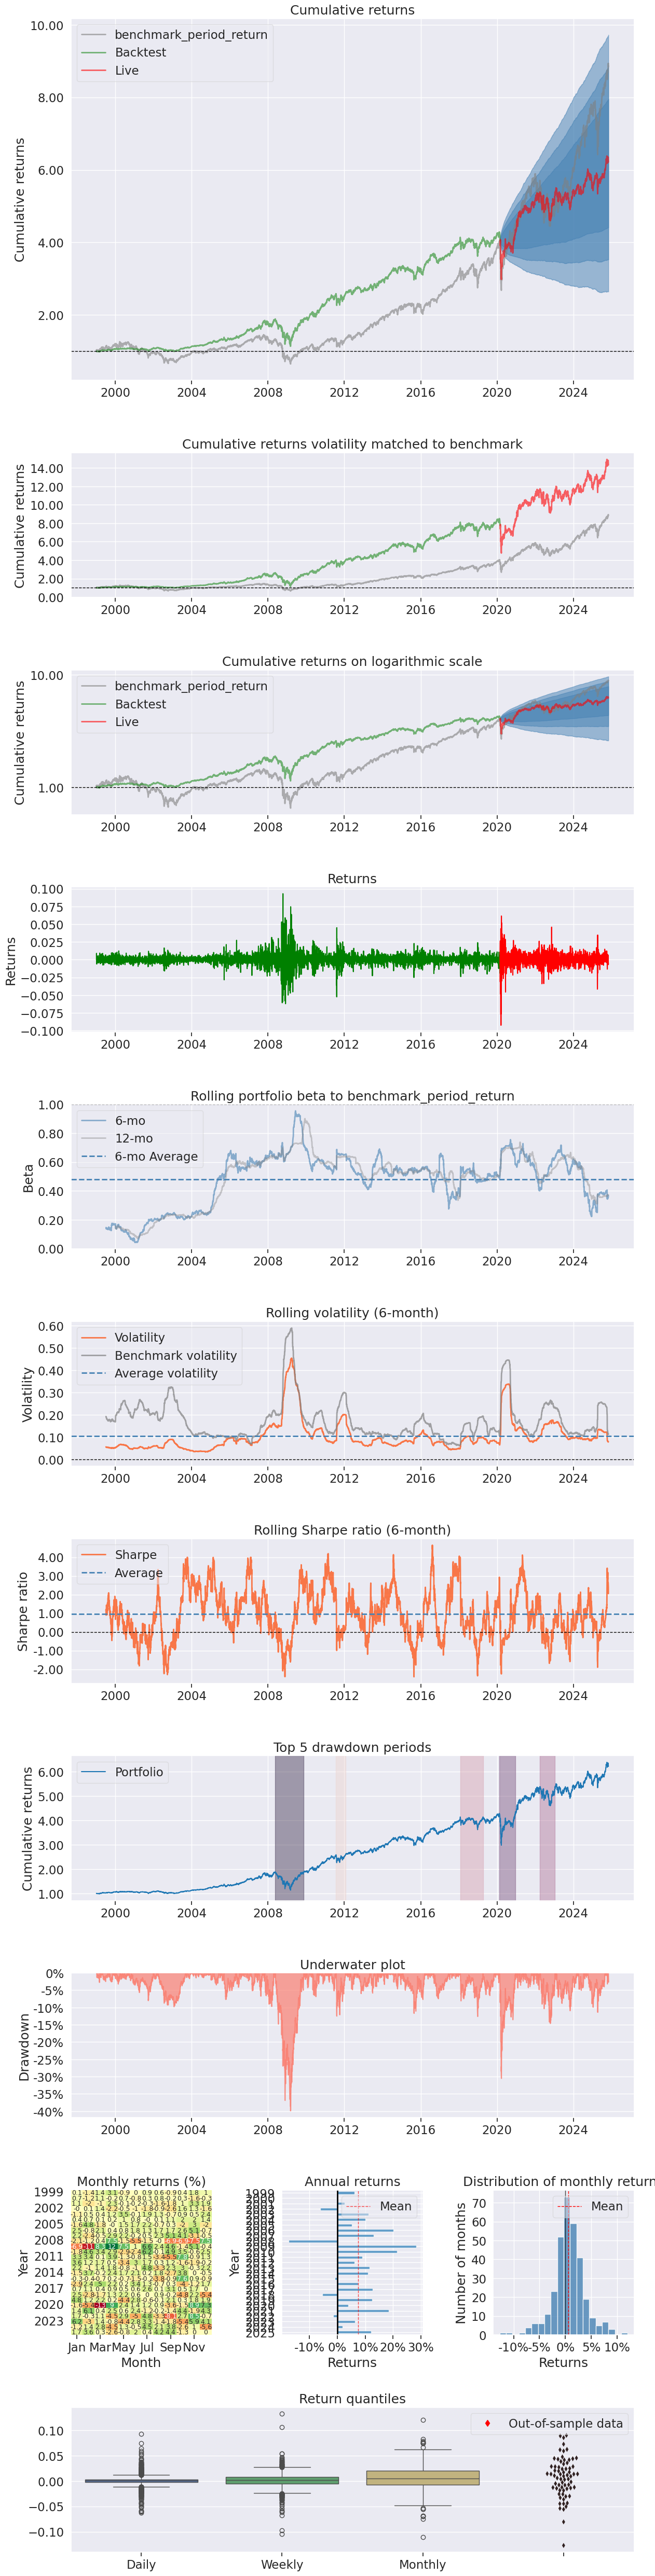

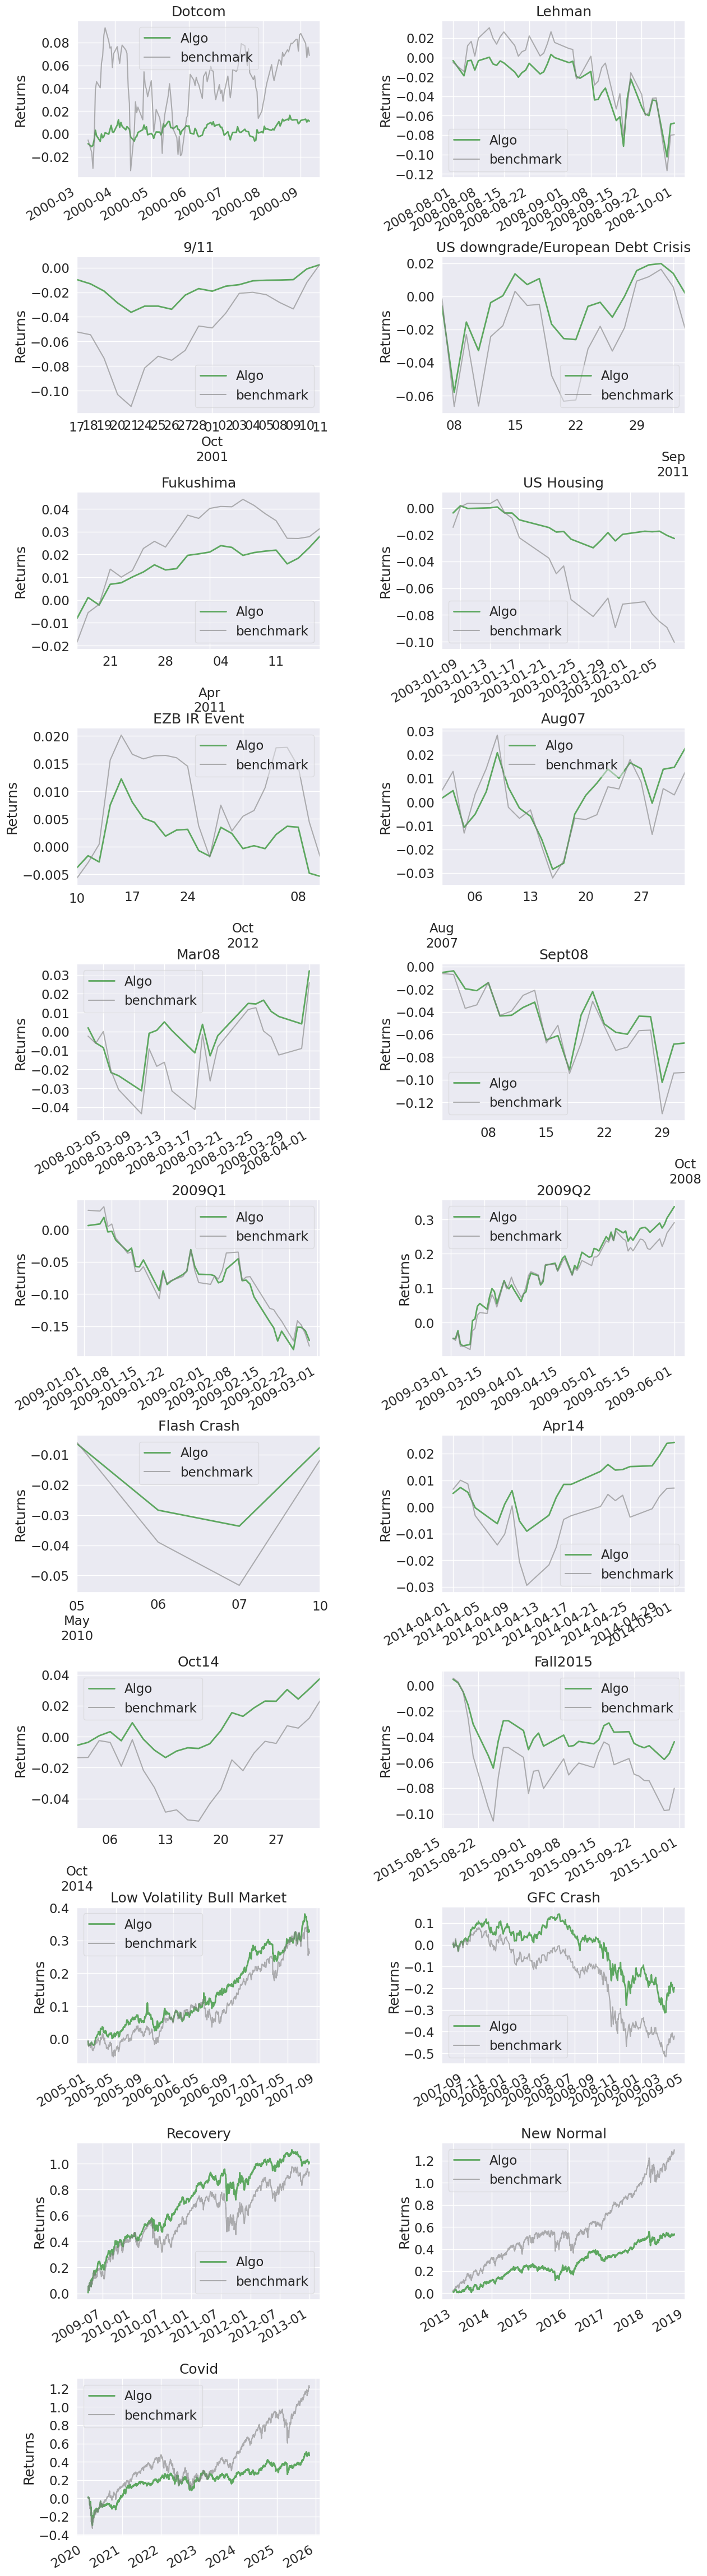

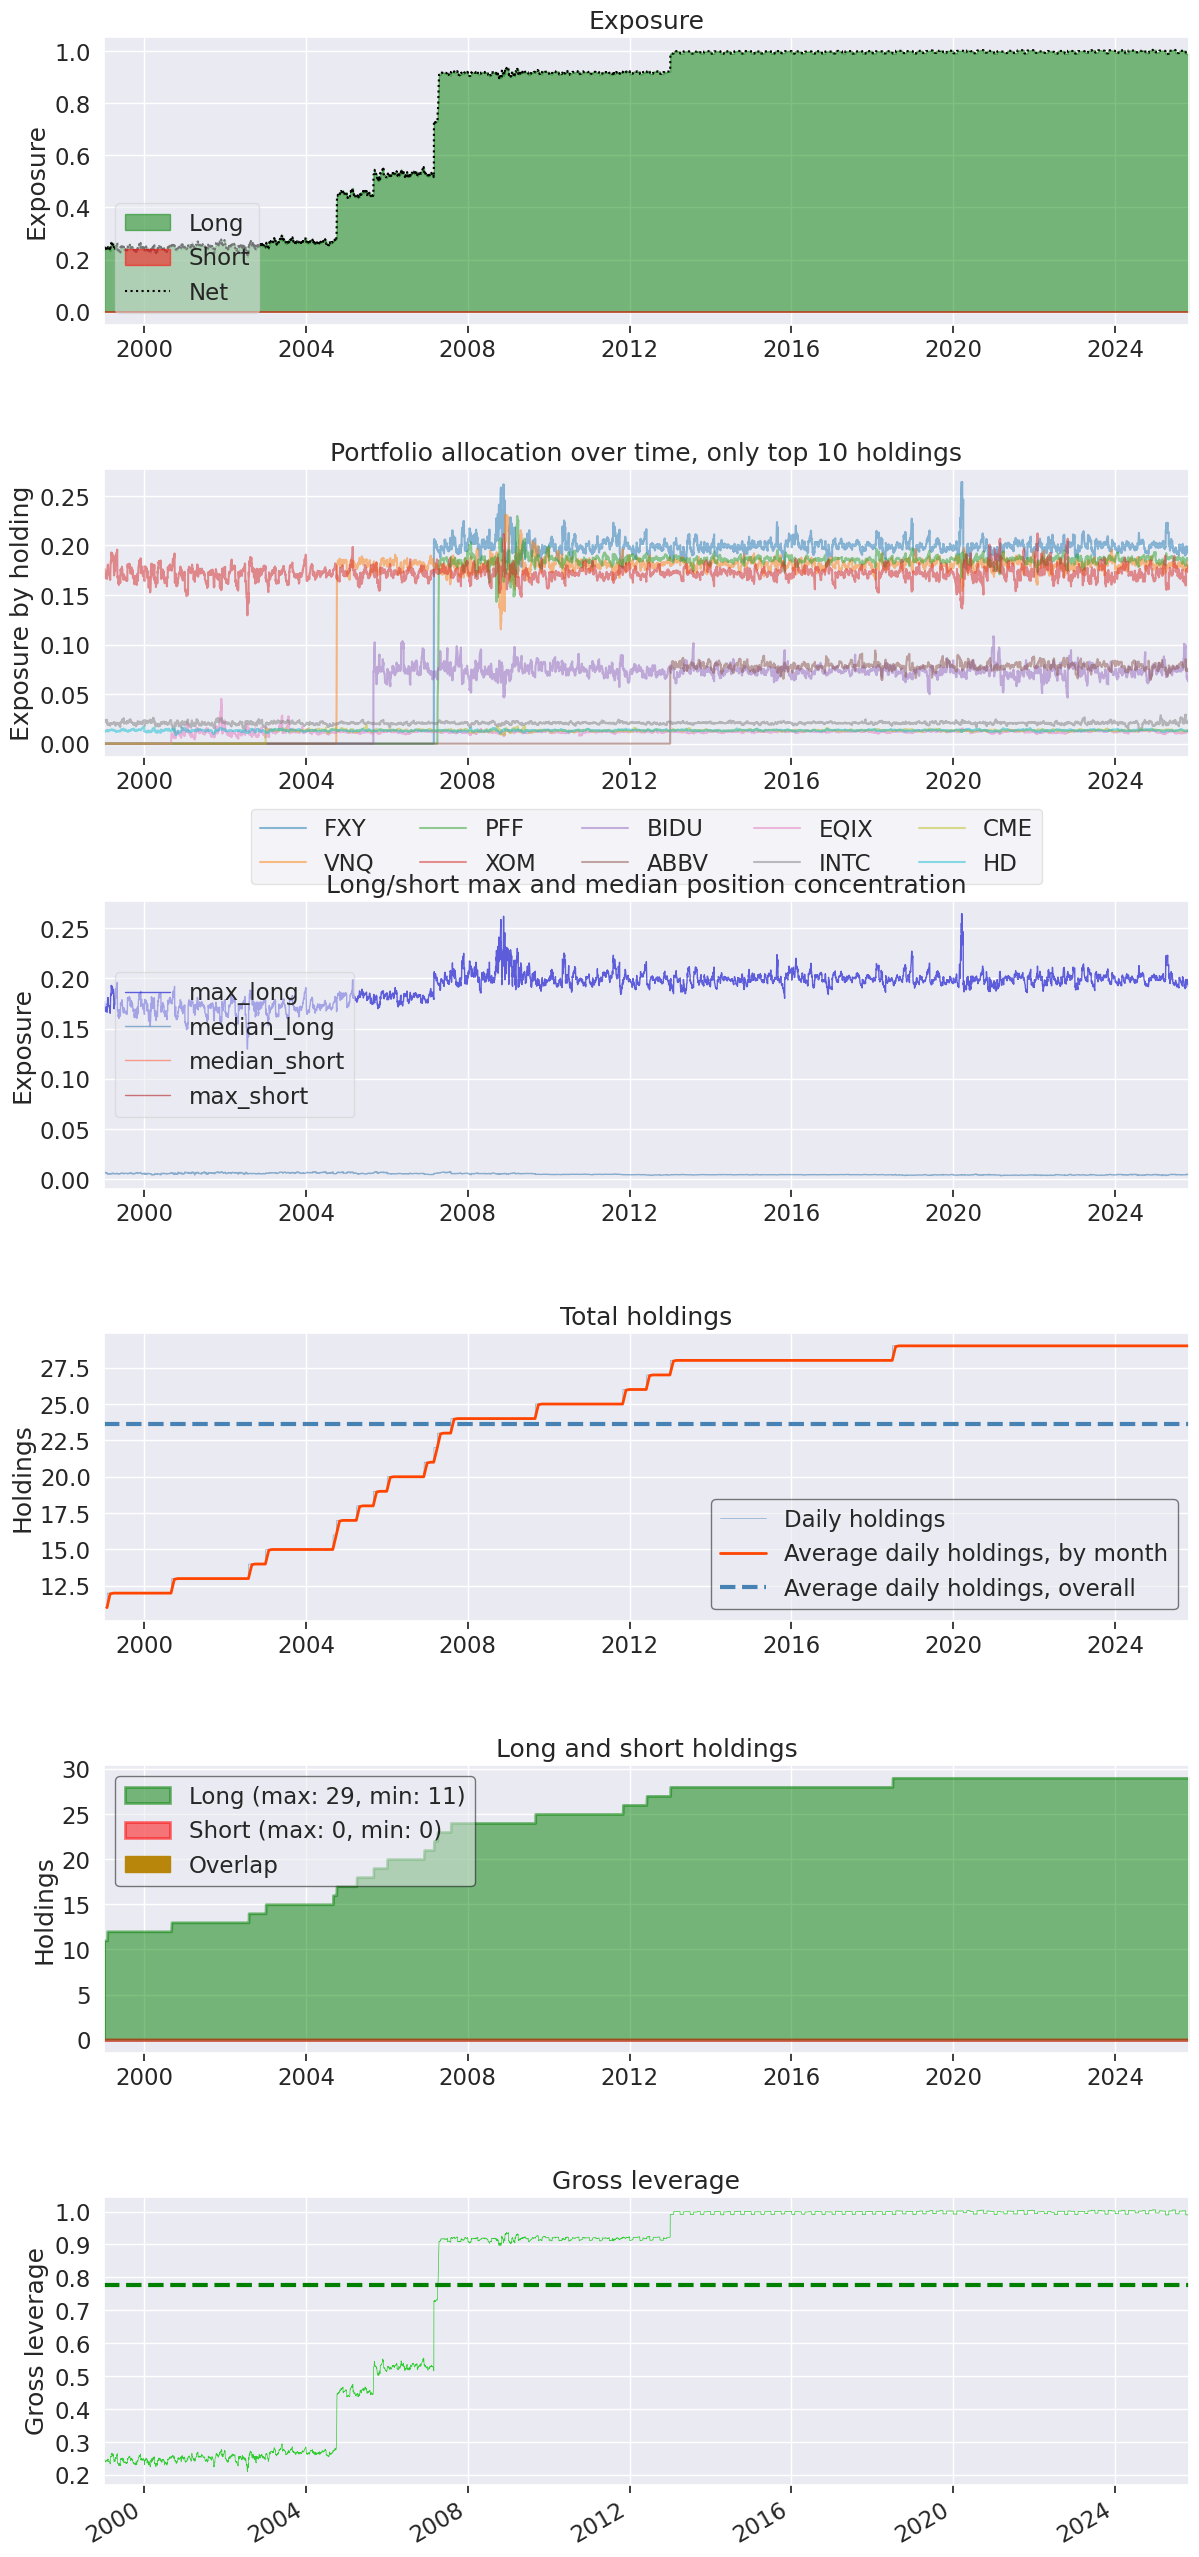

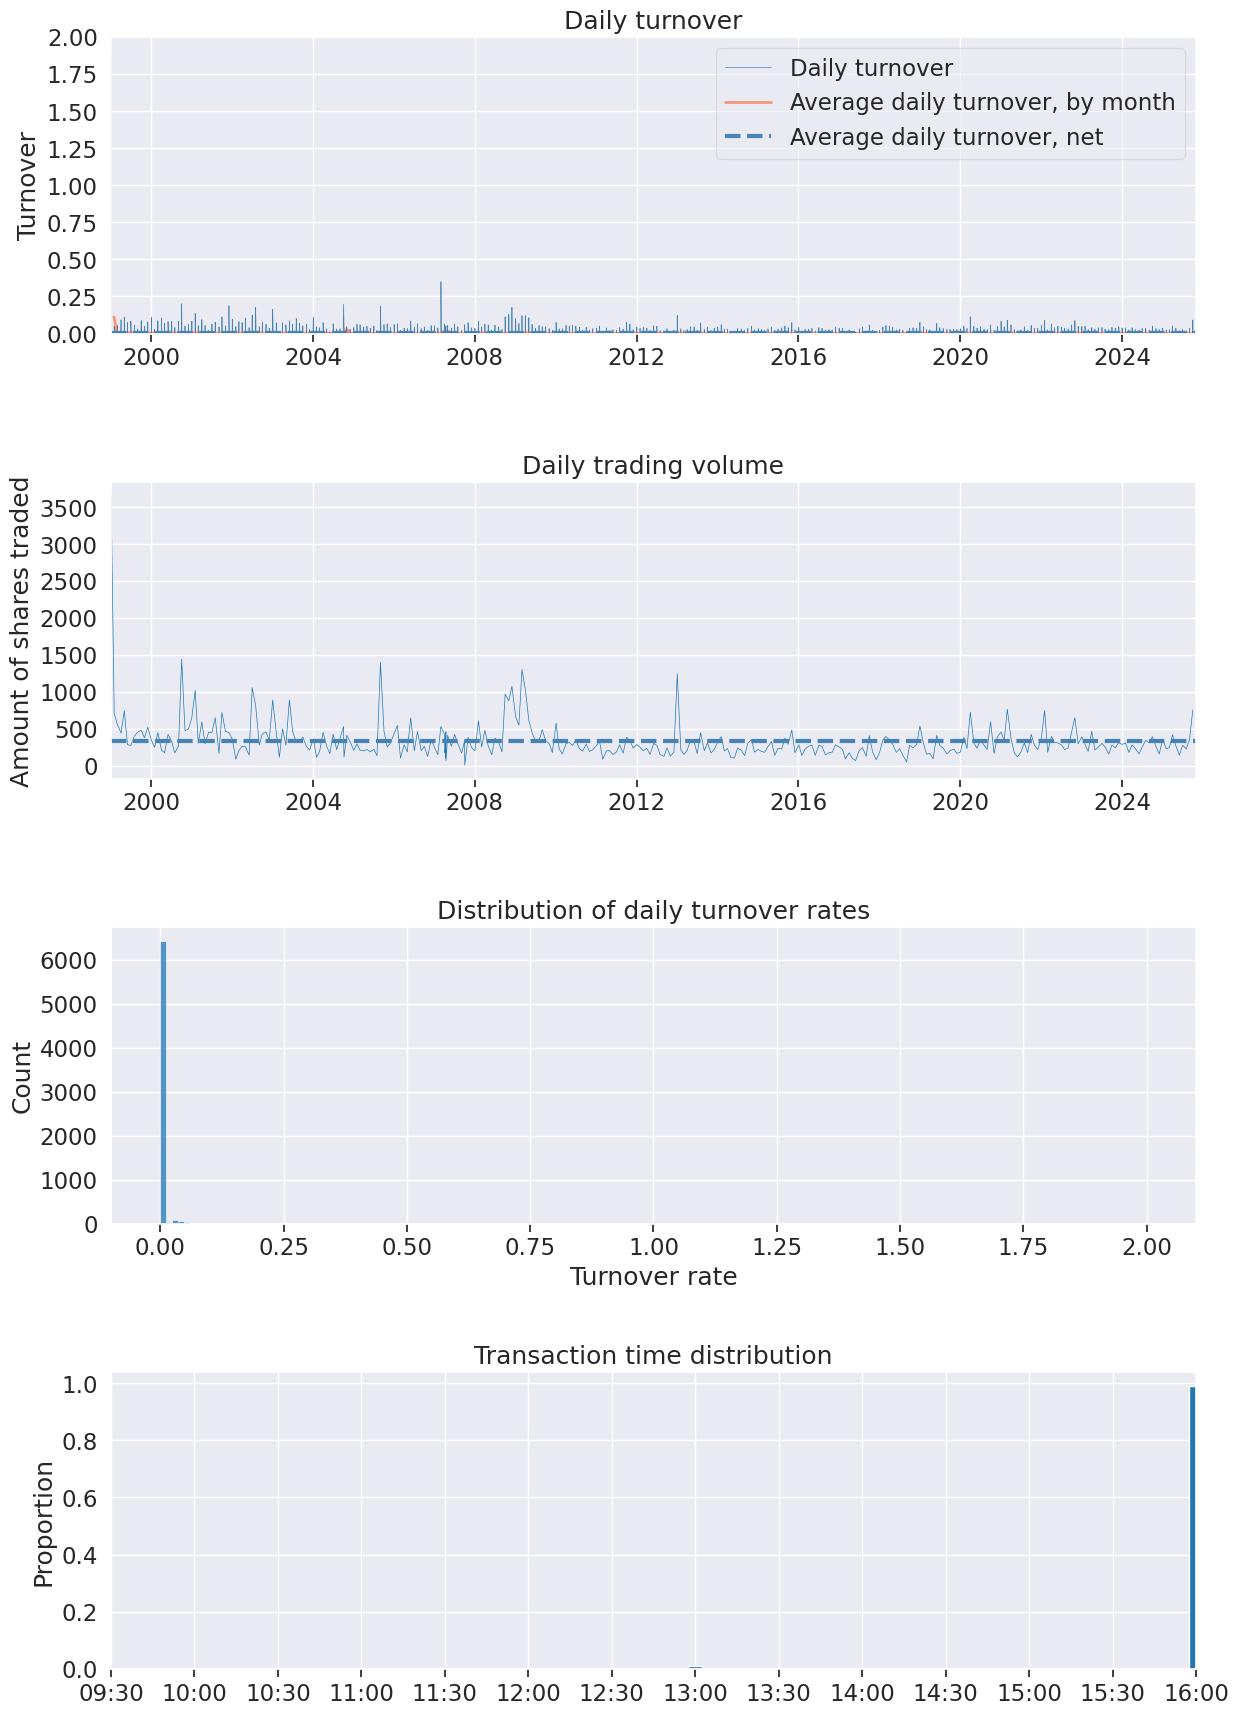

In [38]:
# ============================================================================
# STEP 4: RUN BACKTEST (FIXED TIMEZONE)
# ============================================================================

import pytz

# Use pytz.UTC instead of 'UTC' string
start_date = pd.Timestamp('1999-01-01')
end_date = pd.Timestamp('2025-10-31')

print("\n" + "="*80)
print("RUNNING ZIPLINE BACKTEST")
print("="*80)
print(f"Period: {start_date.date()} to {end_date.date()}")
print(f"Initial Capital: $100,000")
print(f"Management Fee: 1% annual")
print(f"Performance Fee: 20% on excess returns vs SPY")
print(f"Transaction Costs: 10 bps per trade")
print("="*80)

try:
    zipline_results = run_algorithm(
        start=start_date,
        end=end_date,
        initialize=initialize,
        analyze=analyze,
        capital_base=100000,
        data_frequency='daily',
        bundle='term-project-bundle'
    )
    
    print("\n✓ Zipline backtest completed successfully!")
    
except Exception as e:
    print(f"\n✗ Error running backtest: {e}")
    import traceback
    traceback.print_exc()